In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [ ]:
# ── 1.2.1 ENZYMES ──────────────────────────────────────────────────────────
dataset_ENZ = TUDataset(
    root='/tmp/ENZYMES',
    name='ENZYMES',
    transform=OneHotDegree(max_degree=10)
).shuffle()

# According to the paper: ENZYMES has 600 graphs; split 70/10/20 = 420/60/120
train_ENZ = dataset_ENZ[:420]    # first 420 graphs
val_ENZ   = dataset_ENZ[420:480] # next 60 graphs
test_ENZ  = dataset_ENZ[480:]    # last 120 graphs

print(f"ENZ: total={len(dataset_ENZ)} | train={len(train_ENZ)} | val={len(val_ENZ)} | test={len(test_ENZ)}")


Processing...


ENZ: total=600 | train=420 | val=60 | test=120


Done!


In [ ]:
# ── 1.2.2 PROTEINS ─────────────────────────────────────────────────────────
dataset_PRO = TUDataset(
    root='/tmp/PROTEINS',
    name='PROTEINS',
    transform=OneHotDegree(max_degree=10)
).shuffle()

# PROTEINS has 1113 graphs; 70%≈779, 10%≈111, 20%≈223
train_PRO = dataset_PRO[:779]
val_PRO   = dataset_PRO[779: 779+111]
test_PRO  = dataset_PRO[779+111:]

print(f"PRO: total={len(dataset_PRO)} | train={len(train_PRO)} | val={len(val_PRO)} | test={len(test_PRO)}")


Processing...


PRO: total=1113 | train=779 | val=111 | test=223


Done!


In [ ]:
# ── 1.3 GCNMean ────────────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)   # [batch_size, hidden_channels]
        return self.lin(x)               # [batch_size, num_classes]


# ── 1.3 GCNDiff ────────────────────────────────────────────────────────────
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        # Note: “Diff” variant often means we add a skip connection after each layer.
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x0 = x  # initial input
        x1 = F.relu(self.conv1(x0, edge_index)) + x0   # residual
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        x2 = F.relu(self.conv2(x1, edge_index)) + x1   # residual
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        x3 = F.relu(self.conv3(x2, edge_index)) + x2   # residual
        x3 = global_mean_pool(x3, batch)
        return self.lin(x3)


# ── 1.3 SAGEMean ───────────────────────────────────────────────────────────
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


# ── 1.3 SAGEDiff ───────────────────────────────────────────────────────────
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x0 = x
        x1 = F.relu(self.conv1(x0, edge_index)) + x0
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        x2 = F.relu(self.conv2(x1, edge_index)) + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        x3 = F.relu(self.conv3(x2, edge_index)) + x2
        x3 = global_mean_pool(x3, batch)
        return self.lin(x3)


In [ ]:
def train_graph_cls_victim(
    model: nn.Module,
    train_dataset: TUDataset,
    val_dataset: TUDataset,
    test_dataset: TUDataset,
    model_name: str,
    num_epochs: int = 200,
    batch_size: int = 32,
    lr: float = 0.01,
    weight_decay: float = 5e-4
):
    """
    Trains `model` on train_dataset, monitors val_dataset, and returns test accuracy.
    Saves the best‐validation checkpoint as "{model_name}.pth".
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_state   = None

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        total_loss = 0.0; correct = 0; total = 0
        for batch in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  # logits [batch_size, num_classes]
            labels = batch.y.view(-1)
            loss = loss_fn(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.num_graphs
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += batch.num_graphs

        train_acc = correct / total

        # Validation
        model.eval()
        correct_val = 0; total_val = 0
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
                correct_val += (out == batch.y.view(-1)).sum().item()
                total_val += batch.num_graphs
        val_acc = correct_val / total_val

        # Save best‐val checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state   = model.state_dict()

        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f"[{model_name}] Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Load best‐val before computing final test accuracy
    if best_state is not None:
        model.load_state_dict(best_state)

    # Test accuracy
    model.eval()
    correct_test = 0; total_test = 0
    with torch.no_grad():
        for batch in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct_test += (out == batch.y.view(-1)).sum().item()
            total_test += batch.num_graphs
    test_acc = correct_test / total_test

    # Save final best‐val weights
    torch.save(model.state_dict(), f"victim_{model_name}.pth")
    print(f"[{model_name}] Best val acc {best_val_acc:.4f} → saved to victim_{model_name}.pth | Test Acc {test_acc:.4f}")

    return test_acc


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Load ENZYMES (70∶10∶20 split)
# ─────────────────────────────────────────────────────────────────────────────
dataset_ENZ = TUDataset(
    root='/tmp/ENZYMES',
    name='ENZYMES',
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]    # 420 graphs
val_ENZ   = dataset_ENZ[420:480] # 60 graphs
test_ENZ  = dataset_ENZ[480:]    # 120 graphs

print(f"ENZYMES: total={len(dataset_ENZ)} | train={len(train_ENZ)} | val={len(val_ENZ)} | test={len(test_ENZ)}")


# ─────────────────────────────────────────────────────────────────────────────
# 2. Define GCNMean, GCNDiff, SAGEMean, SAGEDiff (with corrected residuals)
# ─────────────────────────────────────────────────────────────────────────────

# ── 2.1 GCNMean ─────────────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


# ── 2.2 Corrected GCNDiff ─────────────────────────────────────────────────────
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        # If in_channels != hidden_channels, project input x0 → hidden_channels before adding
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        # Project x0 if needed
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        # Layer 1 + residual
        h1 = F.relu(self.conv1(x0, edge_index))      # [num_nodes, hidden_channels]
        x1 = h1 + x0_proj                             # project‐skip + conv output
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        # Layer 2 + residual
        h2 = F.relu(self.conv2(x1, edge_index))       # [num_nodes, hidden_channels]
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        # Layer 3 + residual
        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)             # [batch_size, hidden_channels]
        return self.lin(out)                          # [batch_size, num_classes]


# ── 2.3 SAGEMean ─────────────────────────────────────────────────────────────
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


# ── 2.4 Corrected SAGEDiff ────────────────────────────────────────────────────
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        # Project inputs if needed
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        # Layer 1 + residual
        h1 = F.relu(self.conv1(x0, edge_index))       # [num_nodes, hidden_channels]
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        # Layer 2 + residual
        h2 = F.relu(self.conv2(x1, edge_index))       # [num_nodes, hidden_channels]
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        # Layer 3 + residual
        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)              # [batch_size, hidden_channels]
        return self.lin(out)                           # [batch_size, num_classes]


# ─────────────────────────────────────────────────────────────────────────────
# 3. Train all four victims on ENZYMES
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3.1 GCNMean
model_name = "ENZ_GCNMean"
model = GCNMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_GCNMean = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)

# 3.2 GCNDiff
model_name = "ENZ_GCNDiff"
model = GCNDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_GCNDiff = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)

# 3.3 SAGEMean
model_name = "ENZ_SAGEMean"
model = SAGEMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_SAGEMean = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)

# 3.4 SAGEDiff
model_name = "ENZ_SAGEDiff"
model = SAGEDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_SAGEDiff = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)


ENZYMES: total=600 | train=420 | val=60 | test=120
[ENZ_GCNMean] Epoch 001 | Train Acc: 0.1738 | Val Acc: 0.2667
[ENZ_GCNMean] Epoch 020 | Train Acc: 0.2500 | Val Acc: 0.2000
[ENZ_GCNMean] Epoch 040 | Train Acc: 0.3000 | Val Acc: 0.2833
[ENZ_GCNMean] Epoch 060 | Train Acc: 0.3381 | Val Acc: 0.2833
[ENZ_GCNMean] Epoch 080 | Train Acc: 0.3905 | Val Acc: 0.3500
[ENZ_GCNMean] Epoch 100 | Train Acc: 0.3786 | Val Acc: 0.2667
[ENZ_GCNMean] Epoch 120 | Train Acc: 0.3929 | Val Acc: 0.3167
[ENZ_GCNMean] Epoch 140 | Train Acc: 0.3881 | Val Acc: 0.2667
[ENZ_GCNMean] Epoch 160 | Train Acc: 0.4190 | Val Acc: 0.2833
[ENZ_GCNMean] Epoch 180 | Train Acc: 0.4333 | Val Acc: 0.2667
[ENZ_GCNMean] Epoch 200 | Train Acc: 0.4714 | Val Acc: 0.2333
[ENZ_GCNMean] Best val acc 0.3500 → saved to victim_ENZ_GCNMean.pth | Test Acc 0.4000
[ENZ_GCNDiff] Epoch 001 | Train Acc: 0.1738 | Val Acc: 0.2667
[ENZ_GCNDiff] Epoch 020 | Train Acc: 0.3381 | Val Acc: 0.2333
[ENZ_GCNDiff] Epoch 040 | Train Acc: 0.3762 | Val Acc: 0.

In [ ]:
!mkdir -p /content/drive/MyDrive/gnnfingers/checkpoints
!mkdir -p /content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/positive
!mkdir -p /content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/negative


In [ ]:
# Copy the victim models
!cp /content/victim_ENZ_GCNMean.pth   /content/drive/MyDrive/gnnfingers/checkpoints/
!cp /content/victim_ENZ_GCNDiff.pth   /content/drive/MyDrive/gnnfingers/checkpoints/
!cp /content/victim_ENZ_SAGEMean.pth  /content/drive/MyDrive/gnnfingers/checkpoints/
!cp /content/victim_ENZ_SAGEDiff.pth /content/drive/MyDrive/gnnfingers/checkpoints/

# Copy the positive & negative variants you generated
!cp -r /content/variants/ENZ_GCNMean/positive   /content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/
!cp -r /content/variants/ENZ_GCNMean/negative   /content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/


In [ ]:
# List the checkpoint folder
!ls /content/drive/MyDrive/gnnfingers/checkpoints

# List the variants folder
!ls /content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/positive | head


victim_ENZ_GCNDiff.pth	victim_ENZ_SAGEDiff.pth
victim_ENZ_GCNMean.pth	victim_ENZ_SAGEMean.pth


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 0) Make sure these top-level folders exist (they’ll be relative to your notebook)
os.makedirs("ENZYMES", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("variants/ENZ_GCNMean/positive", exist_ok=True)
os.makedirs("variants/ENZ_GCNMean/negative", exist_ok=True)
os.makedirs("variants/ENZ_GCNDiff/positive", exist_ok=True)
os.makedirs("variants/ENZ_GCNDiff/negative", exist_ok=True)
os.makedirs("variants/ENZ_SAGEMean/positive", exist_ok=True)
os.makedirs("variants/ENZ_SAGEMean/negative", exist_ok=True)
os.makedirs("variants/ENZ_SAGEDiff/positive", exist_ok=True)
os.makedirs("variants/ENZ_SAGEDiff/negative", exist_ok=True)

# 1) Load ENZYMES without an absolute path—this creates a folder "./ENZYMES"
dataset_ENZ = TUDataset(root="ENZYMES",
                        name="ENZYMES",
                        transform=OneHotDegree(max_degree=10)).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

print(f"ENZYMES: total={len(dataset_ENZ)} | train={len(train_ENZ)} | val={len(val_ENZ)} | test={len(test_ENZ)}")

# 2) Define architectures (GCNMean, corrected GCNDiff, SAGEMean, corrected SAGEDiff)

class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 3) Helper to train & save victims (again, saves to "./checkpoints/victim_<model_name>.pth")
def train_graph_cls_victim(model, train_dataset, val_dataset, test_dataset, model_name,
                           num_epochs=200, batch_size=32, lr=0.01, weight_decay=5e-4):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    best_val_acc, best_state = 0.0, None

    for epoch in range(1, num_epochs+1):
        model.train()
        total_correct, total = 0, 0
        for batch in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            total_correct += (preds == batch.y.view(-1)).sum().item()
            total += batch.num_graphs

        train_acc = total_correct / total

        # Validate
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
                batch = batch.to(device)
                preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
                val_correct += (preds == batch.y.view(-1)).sum().item()
                val_total += batch.num_graphs
        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc, best_state = val_acc, model.state_dict()

        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f"[{model_name}] Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    # Test
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            test_correct += (preds == batch.y.view(-1)).sum().item()
            test_total += batch.num_graphs
    test_acc = test_correct / test_total

    torch.save(model.state_dict(), f"checkpoints/victim_{model_name}.pth")
    print(f"[{model_name}] Best val acc {best_val_acc:.4f} → saved to checkpoints/victim_{model_name}.pth | Test Acc {test_acc:.4f}")
    return test_acc

# 4) Train each ENZ “victim” without any absolute paths
test_acc_ENZ_GCNMean = train_graph_cls_victim(
    GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_GCNMean"
)

test_acc_ENZ_GCNDiff = train_graph_cls_victim(
    GCNDiff(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_GCNDiff"
)

test_acc_ENZ_SAGEMean = train_graph_cls_victim(
    SAGEMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_SAGEMean"
)

test_acc_ENZ_SAGEDiff = train_graph_cls_victim(
    SAGEDiff(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_SAGEDiff"
)

# 5) Now generate positive/negative variants for ENZ_GCNMean, using relative paths:
# ─────────────────────────────────────────────────────────────────────────────

# Positive variants for ENZ_GCNMean
for vid in range(200):
    model = GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_ENZ_GCNMean.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, param in model.named_parameters():
            if "lin" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill GCNMean → SAGEMean
        class SAGEMean(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = SAGEConv(in_channels, hidden_channels)
                self.conv2  = SAGEConv(hidden_channels, hidden_channels)
                self.conv3  = SAGEConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout
            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = SAGEMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature ** 2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_weights = []
        for param in model.parameters():
            if param.requires_grad:
                all_weights.append(param.view(-1).cpu().abs())
        all_weights = torch.cat(all_weights)
        threshold = torch.quantile(all_weights, 0.10)
        with torch.no_grad():
            for param in model.parameters():
                mask = param.abs() < threshold.to(param.device)
                param[mask] = 0.0

    torch.save(model.state_dict(), f"variants/ENZ_GCNMean/positive/positive_{vid:03d}.pth")

print("Done 200 positive variants for ENZ_GCNMean.")

# Negative variants for ENZ_GCNMean
for vid in range(200):
    model = GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid)
    random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/ENZ_GCNMean/negative/negative_{vid:03d}.pth")

print("Done 200 negative variants for ENZ_GCNMean.")


ENZYMES: total=600 | train=420 | val=60 | test=120
[ENZ_GCNMean] Epoch 001 | Train Acc: 0.1262 | Val Acc: 0.1167
[ENZ_GCNMean] Epoch 020 | Train Acc: 0.2667 | Val Acc: 0.2500
[ENZ_GCNMean] Epoch 040 | Train Acc: 0.3405 | Val Acc: 0.3000


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load ENZ (relative to "./ENZYMES" folder)
dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) Define the same GCNMean as before
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 3) Reload victim_ENZ_GCNMean
victim_path = os.path.join("checkpoints", "victim_ENZ_GCNMean.pth")
victim_ENZ_GCNMean = GCNMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_GCNMean.load_state_dict(torch.load(victim_path = os.path.join("checkpoints", "victim_ENZ_GCNMean.pth")
, map_location=device))
victim_ENZ_GCNMean.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define and train U_ENZ_GCNMean (FingerprintNetMLP) – Block 4
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)  # [batch_size, 128]
        return self.net(x)                          # [batch_size, 2]

U_ENZ_GCNMean = FingerprintNetMLP_ENZ(
    embed_dim=64,
    key_dim=64,
    hidden1=256,
    hidden2=128,
    hidden3=64,
    dropout=0.5
).to(device)

# 4) Collect 100 “victim” embeddings (label=1) from train_ENZ[:100]
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        # We need the 64‐dim “pooled” output from the last conv:
        # Modify GCNMean to also return its pooled vector if needed; here we recompute:
        x1 = F.relu(victim_ENZ_GCNMean.conv1(batch.x, batch.edge_index))
        x1 = F.dropout(x1, p=victim_ENZ_GCNMean.dropout, training=False)
        x2 = F.relu(victim_ENZ_GCNMean.conv2(x1, batch.edge_index))
        x2 = F.dropout(x2, p=victim_ENZ_GCNMean.dropout, training=False)
        x3 = F.relu(victim_ENZ_GCNMean.conv3(x2, batch.edge_index))
        pooled = global_mean_pool(x3, batch.batch)  # [batch_size, 64]
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings from 20 negative variants (5 each)
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # = 5

for neg_i in range(num_neg_models):
    neg_model = GCNMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNMean", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            x1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            x1 = F.dropout(x1, p=neg_model.dropout, training=False)
            x2 = F.relu(neg_model.conv2(x1, batch.edge_index))
            x2 = F.dropout(x2, p=neg_model.dropout, training=False)
            x3 = F.relu(neg_model.conv3(x2, batch.edge_index))
            pooled_neg = global_mean_pool(x3, batch.batch)  # [batch_size, 64]
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s training loader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([pair[0] for pair in fp_pairs], dim=0)  # [200, 64]
labels   = torch.tensor([pair[1] for pair in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

print("U’s training set ready: features [200,64], labels [200]")

# Train U_ENZ_GCNMean
opt_U = torch.optim.Adam(U_ENZ_GCNMean.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_GCNMean.train()
    total_loss = 0.0
    correct_fp = 0
    total_fp = 0

    for (emb_batch, lbl_batch) in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)

        logits = U_ENZ_GCNMean(emb_batch)     # [batch_size, 2]
        loss = loss_fn_fp(logits, lbl_batch)

        opt_U.zero_grad()
        loss.backward()
        opt_U.step()

        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_loss = total_loss / total_fp
    train_acc  = correct_fp / total_fp
    print(f"[U_ENZ_GCNMean] Epoch {epoch:03d} | U-loss: {train_loss:.4f} | U-acc: {train_acc:.4f}")

    if train_acc >= 0.95:
        print(f"→ Reached 95% accuracy at epoch {epoch}, stopping early.")
        break

U_ENZ_GCNMean.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_GCNMean.state_dict(), "checkpoints/U_ENZ_GCNMean.pth")
print("Finished training U_ENZ_GCNMean; saved to checkpoints/U_ENZ_GCNMean.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper to extract a single model’s fingerprint
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval()
    U_net.eval()
    pooled_list = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x1 = F.relu(model.conv1(batch.x, batch.edge_index))
            x1 = F.dropout(x1, p=model.dropout, training=False)
            x2 = F.relu(model.conv2(x1, batch.edge_index))
            x2 = F.dropout(x2, p=model.dropout, training=False)
            x3 = F.relu(model.conv3(x2, batch.edge_index))
            pooled = global_mean_pool(x3, batch.batch)  # [batch_size, 64]
            pooled_list.append(pooled.cpu())

    all_pooled = torch.cat(pooled_list, dim=0)  # [Q, 64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q, 128]
        features = U_net.net[:-1](x)  # [Q, hidden3=64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

# Build query_loader from test_ENZ[:100]
query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_GCNMean, U_ENZ_GCNMean, query_loader)  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200 × 64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = GCNMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNMean", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_GCNMean, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200, 64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R = 5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed)
    random.seed(seed)
    model = GCNMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            labels = batch.y.view(-1)
            loss = loss_fn(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_GCNMean, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5, 64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity scores: robustness (R) and uniqueness (K)
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)  # [1, 64]
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # shape [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # shape [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: sweep τ ∈ [-1, 1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []
FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR)
FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot and save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6, 6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ GCNMean (R=5, K=200, Q=100)")
plt.grid(True)
plt.tight_layout()
plt.savefig("ARUC_ENZ_GCNMean_Q100.png")
plt.show()


ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, GCNDiff victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) Corrected GCNDiff definition (same as you used when training)
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 3) Reload victim_ENZ_GCNDiff
victim_path = os.path.join("checkpoints", "victim_ENZ_GCNDiff.pth")
victim_ENZ_GCNDiff = GCNDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_GCNDiff.load_state_dict(torch.load(victim_path, map_location=device))
victim_ENZ_GCNDiff.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define & train U_ENZ_GCNDiff
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)

U_ENZ_GCNDiff = FingerprintNetMLP_ENZ().to(device)

# 4) Collect 100 “victim” embeddings with label=1 (train_ENZ[:100])
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        # Manually extract pooled 64‐d vector:
        h1 = F.relu(victim_ENZ_GCNDiff.conv1(batch.x, batch.edge_index))
        h1 = F.dropout(h1, p=victim_ENZ_GCNDiff.dropout, training=False)
        h2 = F.relu(victim_ENZ_GCNDiff.conv2(h1, batch.edge_index))
        h2 = F.dropout(h2, p=victim_ENZ_GCNDiff.dropout, training=False)
        h3 = F.relu(victim_ENZ_GCNDiff.conv3(h2, batch.edge_index))
        pooled = global_mean_pool(h3, batch.batch)  # [batch_size,64]
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings from 20 negative models (5 per model)
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # 5

for neg_i in range(num_neg_models):
    neg_model = GCNDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNDiff", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            h1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=neg_model.dropout, training=False)
            h2 = F.relu(neg_model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=neg_model.dropout, training=False)
            h3 = F.relu(neg_model.conv3(h2, batch.edge_index))
            pooled_neg = global_mean_pool(h3, batch.batch)  # [batch_size,64]
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s training DataLoader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([p[0] for p in fp_pairs], dim=0)  # [200,64]
labels   = torch.tensor([p[1] for p in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

# Train U_ENZ_GCNDiff
opt_U = torch.optim.Adam(U_ENZ_GCNDiff.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_GCNDiff.train()
    total_loss = 0.0; correct_fp = 0; total_fp = 0
    for emb_batch, lbl_batch in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        logits = U_ENZ_GCNDiff(emb_batch)
        loss = loss_fn_fp(logits, lbl_batch)
        opt_U.zero_grad()
        loss.backward()
        opt_U.step()
        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_acc = correct_fp / total_fp
    print(f"[U_ENZ_GCNDiff] Epoch {epoch:03d} | U-loss: {total_loss/total_fp:.4f} | U-acc: {train_acc:.4f}")
    if train_acc >= 0.95:
        print(f"→ Reached 95% at epoch {epoch}, stopping")
        break

U_ENZ_GCNDiff.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_GCNDiff.state_dict(), "checkpoints/U_ENZ_GCNDiff.pth")
print("Saved U_ENZ_GCNDiff to checkpoints/U_ENZ_GCNDiff.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper: extract graph‐cls fingerprint using U
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval(); U_net.eval()
    pooled_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            h1 = F.relu(model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=model.dropout, training=False)
            h2 = F.relu(model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=model.dropout, training=False)
            h3 = F.relu(model.conv3(h2, batch.edge_index))
            pooled = global_mean_pool(h3, batch.batch)  # [batch_size,64]
            pooled_list.append(pooled.cpu())
    all_pooled = torch.cat(pooled_list, dim=0)  # [Q,64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q,128]
        features = U_net.net[:-1](x)  # [Q,64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_GCNDiff, U_ENZ_GCNDiff, query_loader)


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200×64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = GCNDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNDiff", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()
    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_GCNDiff, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200,64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R=5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ_diff(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed); random.seed(seed)
    model = GCNDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ_diff(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_GCNDiff, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5,64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity: robustness & uniqueness
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)                     # [1,64]
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: thresholds ∈ [−1,1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []; FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR); FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot & save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6,6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ GCNDiff (R=5, K=200, Q=100)")
plt.grid(True); plt.tight_layout()
plt.savefig("ARUC_ENZ_GCNDiff_Q100.png")
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, SAGEMean victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) SAGEMean definition
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 3) Reload victim_ENZ_SAGEMean
victim_path = os.path.join("checkpoints", "victim_ENZ_SAGEMean.pth")
victim_ENZ_SAGEMean = SAGEMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_SAGEMean.load_state_dict(torch.load(victim_path, map_location=device))
victim_ENZ_SAGEMean.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define & train U_ENZ_SAGEMean
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)

U_ENZ_SAGEMean = FingerprintNetMLP_ENZ().to(device)

# 4) Collect 100 victim embeddings (train_ENZ[:100])
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        h1 = F.relu(victim_ENZ_SAGEMean.conv1(batch.x, batch.edge_index))
        h1 = F.dropout(h1, p=victim_ENZ_SAGEMean.dropout, training=False)
        h2 = F.relu(victim_ENZ_SAGEMean.conv2(h1, batch.edge_index))
        h2 = F.dropout(h2, p=victim_ENZ_SAGEMean.dropout, training=False)
        h3 = F.relu(victim_ENZ_SAGEMean.conv3(h2, batch.edge_index))
        pooled = global_mean_pool(h3, batch.batch)
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings from 20 negative models
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # 5

for neg_i in range(num_neg_models):
    neg_model = SAGEMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEMean", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            h1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=neg_model.dropout, training=False)
            h2 = F.relu(neg_model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=neg_model.dropout, training=False)
            h3 = F.relu(neg_model.conv3(h2, batch.edge_index))
            pooled_neg = global_mean_pool(h3, batch.batch)
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s DataLoader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([p[0] for p in fp_pairs], dim=0)  # [200,64]
labels   = torch.tensor([p[1] for p in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

opt_U = torch.optim.Adam(U_ENZ_SAGEMean.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_SAGEMean.train()
    total_loss = 0.0; correct_fp = 0; total_fp = 0
    for emb_batch, lbl_batch in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        logits = U_ENZ_SAGEMean(emb_batch)
        loss = loss_fn_fp(logits, lbl_batch)
        opt_U.zero_grad()
        loss.backward()
        opt_U.step()
        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_acc = correct_fp / total_fp
    print(f"[U_ENZ_SAGEMean] Epoch {epoch:03d} | U-loss: {total_loss/total_fp:.4f} | U-acc: {train_acc:.4f}")
    if train_acc >= 0.95:
        print(f"→ Reached 95% at epoch {epoch}, stopping")
        break

U_ENZ_SAGEMean.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_SAGEMean.state_dict(), "checkpoints/U_ENZ_SAGEMean.pth")
print("Saved U_ENZ_SAGEMean to checkpoints/U_ENZ_SAGEMean.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper: extract fingerprint
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval(); U_net.eval()
    pooled_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            h1 = F.relu(model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=model.dropout, training=False)
            h2 = F.relu(model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=model.dropout, training=False)
            h3 = F.relu(model.conv3(h2, batch.edge_index))
            pooled = global_mean_pool(h3, batch.batch)
            pooled_list.append(pooled.cpu())
    all_pooled = torch.cat(pooled_list, dim=0)  # [Q,64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q,128]
        features = U_net.net[:-1](x)  # [Q,64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_SAGEMean, U_ENZ_SAGEMean, query_loader)


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200×64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = SAGEMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEMean", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()
    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_SAGEMean, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200,64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R=5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ_sage(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed); random.seed(seed)
    model = SAGEMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ_sage(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_SAGEMean, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5,64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity: robustness & uniqueness
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: thresholds ∈ [−1,1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []; FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR); FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot & save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6,6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ SAGEMean (R=5, K=200, Q=100)")
plt.grid(True); plt.tight_layout()
plt.savefig("ARUC_ENZ_SAGEMean_Q100.png")
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, SAGEDiff victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) Corrected SAGEDiff definition
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 3) Reload victim_ENZ_SAGEDiff
victim_path = os.path.join("checkpoints", "victim_ENZ_SAGEDiff.pth")
victim_ENZ_SAGEDiff = SAGEDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_SAGEDiff.load_state_dict(torch.load(victim_path, map_location=device))
victim_ENZ_SAGEDiff.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define & train U_ENZ_SAGEDiff
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)

U_ENZ_SAGEDiff = FingerprintNetMLP_ENZ().to(device)

# 4) Collect 100 victim embeddings (train_ENZ[:100])
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        h1 = F.relu(victim_ENZ_SAGEDiff.conv1(batch.x, batch.edge_index))
        h1 = F.dropout(h1, p=victim_ENZ_SAGEDiff.dropout, training=False)
        h2 = F.relu(victim_ENZ_SAGEDiff.conv2(h1, batch.edge_index))
        h2 = F.dropout(h2, p=victim_ENZ_SAGEDiff.dropout, training=False)
        h3 = F.relu(victim_ENZ_SAGEDiff.conv3(h2, batch.edge_index))
        pooled = global_mean_pool(h3, batch.batch)
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings (20 models × 5 each)
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # 5

for neg_i in range(num_neg_models):
    neg_model = SAGEDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEDiff", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            h1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=neg_model.dropout, training=False)
            h2 = F.relu(neg_model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=neg_model.dropout, training=False)
            h3 = F.relu(neg_model.conv3(h2, batch.edge_index))
            pooled_neg = global_mean_pool(h3, batch.batch)
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s DataLoader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([p[0] for p in fp_pairs], dim=0)  # [200,64]
labels   = torch.tensor([p[1] for p in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

opt_U = torch.optim.Adam(U_ENZ_SAGEDiff.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_SAGEDiff.train()
    total_loss = 0.0; correct_fp = 0; total_fp = 0
    for emb_batch, lbl_batch in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        logits = U_ENZ_SAGEDiff(emb_batch)
        loss = loss_fn_fp(logits, lbl_batch)
        opt_U.zero_grad()
        loss.backward()
        opt_U.step()
        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_acc = correct_fp / total_fp
    print(f"[U_ENZ_SAGEDiff] Epoch {epoch:03d} | U-loss: {total_loss/total_fp:.4f} | U-acc: {train_acc:.4f}")
    if train_acc >= 0.95:
        print(f"→ Reached 95% at epoch {epoch}, stopping")
        break

U_ENZ_SAGEDiff.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_SAGEDiff.state_dict(), "checkpoints/U_ENZ_SAGEDiff.pth")
print("Saved U_ENZ_SAGEDiff to checkpoints/U_ENZ_SAGEDiff.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper: extract fingerprint
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval(); U_net.eval()
    pooled_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            h1 = F.relu(model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=model.dropout, training=False)
            h2 = F.relu(model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=model.dropout, training=False)
            h3 = F.relu(model.conv3(h2, batch.edge_index))
            pooled = global_mean_pool(h3, batch.batch)
            pooled_list.append(pooled.cpu())
    all_pooled = torch.cat(pooled_list, dim=0)  # [Q,64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q,128]
        features = U_net.net[:-1](x)  # [Q,64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_SAGEDiff, U_ENZ_SAGEDiff, query_loader)


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200×64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = SAGEDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEDiff", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()
    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_SAGEDiff, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200,64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R=5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ_sage_diff(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed); random.seed(seed)
    model = SAGEDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ_sage_diff(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_SAGEDiff, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5,64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity: robustness & uniqueness
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: thresholds ∈ [−1,1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []; FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR); FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot & save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6,6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ SAGEDiff (R=5, K=200, Q=100)")
plt.grid(True); plt.tight_layout()
plt.savefig("ARUC_ENZ_SAGEDiff_Q100.png")
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Install PyG (only run once per notebook; comment it out afterwards)
# ─────────────────────────────────────────────────────────────────────────────
!pip install torch torchvision torchaudio --quiet
!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-sparse   -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-cluster  -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-geometric --quiet

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load & split NCI1
# ─────────────────────────────────────────────────────────────────────────────
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create local folders if needed
os.makedirs("NCI1", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("variants/NCI1_GCNMean/positive", exist_ok=True)
os.makedirs("variants/NCI1_GCNMean/negative", exist_ok=True)
os.makedirs("variants/NCI1_GCNDiff/positive", exist_ok=True)
os.makedirs("variants/NCI1_GCNDiff/negative", exist_ok=True)
os.makedirs("variants/NCI1_SAGEMean/positive", exist_ok=True)
os.makedirs("variants/NCI1_SAGEMean/negative", exist_ok=True)
os.makedirs("variants/NCI1_SAGEDiff/positive", exist_ok=True)
os.makedirs("variants/NCI1_SAGEDiff/negative", exist_ok=True)

# Download and split (70∶10∶20)
dataset_NCI1 = TUDataset(
    root="NCI1",
    name="NCI1",
    transform=OneHotDegree(max_degree=10)
).shuffle()

n = len(dataset_NCI1)
n_train = int(0.70 * n)
n_val   = int(0.10 * n)
train_NCI1 = dataset_NCI1[:n_train]
val_NCI1   = dataset_NCI1[n_train : n_train + n_val]
test_NCI1  = dataset_NCI1[n_train + n_val : ]

print(f"NCI1: total={n}   | train={len(train_NCI1)}   | val={len(val_NCI1)}   | test={len(test_NCI1)}")


# ─────────────────────────────────────────────────────────────────────────────
# 2) Define four victim architectures
# ─────────────────────────────────────────────────────────────────────────────

# 2.1 GCNMean
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 2.2 GCNDiff (with projection skip)
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 2.3 SAGEMean
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 2.4 SAGEDiff (with projection skip)
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)


# ─────────────────────────────────────────────────────────────────────────────
# 3) Training helper (same as ENZymES)
# ─────────────────────────────────────────────────────────────────────────────
def train_graph_cls_victim(
    model: nn.Module,
    train_dataset,
    val_dataset,
    test_dataset,
    model_name: str,
    num_epochs: int = 200,
    batch_size: int = 32,
    lr: float = 0.01,
    weight_decay: float = 5e-4
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_state   = None

    for epoch in range(1, num_epochs + 1):
        model.train()
        correct = total = 0
        for batch in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            lbl = batch.y.view(-1)
            loss = loss_fn(out, lbl)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            correct += (preds == lbl).sum().item()
            total += batch.num_graphs
        train_acc = correct / total

        # Validation
        model.eval()
        correct_val = total_val = 0
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
                batch = batch.to(device)
                preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
                correct_val += (preds == batch.y.view(-1)).sum().item()
                total_val += batch.num_graphs
        val_acc = correct_val / total_val

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state   = model.state_dict()

        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f"[{model_name}] Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Load best‐val state, then test
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    correct_test = total_test = 0
    with torch.no_grad():
        for batch in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct_test += (preds == batch.y.view(-1)).sum().item()
            total_test += batch.num_graphs
    test_acc = correct_test / total_test

    ckpt_path = os.path.join("checkpoints", f"victim_NCI1_{model_name}.pth")
    torch.save(model.state_dict(), ckpt_path)
    print(f"[{model_name}] Best val acc {best_val_acc:.4f} → saved to {ckpt_path} | Test Acc {test_acc:.4f}")
    return test_acc


# ─────────────────────────────────────────────────────────────────────────────
# 4) Train all four victims on NCI1
# ─────────────────────────────────────────────────────────────────────────────

# 4.1 GCNMean
test_acc_NCI1_GCNMean = train_graph_cls_victim(
    GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "GCNMean"
)

# 4.2 GCNDiff
test_acc_NCI1_GCNDiff = train_graph_cls_victim(
    GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "GCNDiff"
)

# 4.3 SAGEMean
test_acc_NCI1_SAGEMean = train_graph_cls_victim(
    SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "SAGEMean"
)

# 4.4 SAGEDiff
test_acc_NCI1_SAGEDiff = train_graph_cls_victim(
    SAGEDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "SAGEDiff"
)


# ─────────────────────────────────────────────────────────────────────────────
# 5) Generate 200 positive & 200 negative variants per architecture
# ─────────────────────────────────────────────────────────────────────────────

# (a) NCI1_GCNMean
for vid in range(200):
    model = GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_GCNMean.pth", map_location=device))
    model.eval()

    strat = vid // 50
    # A) fine‐tune last linear only (10 epochs)
    if strat == 0:
        for name, param in model.named_parameters():
            if "lin" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # B) fine‐tune all layers (10 epochs)
    elif strat == 1:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # C) distill GCNMean → SAGEMean (10 epochs)
    elif strat == 2:
        # SAGEMean “student”
        class SAGEMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = SAGEConv(in_channels, hidden_channels)
                self.conv2  = SAGEConv(hidden_channels, hidden_channels)
                self.conv3  = SAGEConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout

            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = SAGEMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature ** 2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # D) prune 10% weights
    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_GCNMean/positive/positive_{vid:03d}.pth")

# Negative variants for NCI1_GCNMean
for vid in range(200):
    model = GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_GCNMean/negative/negative_{vid:03d}.pth")


# (b) NCI1_GCNDiff
for vid in range(200):
    model = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_GCNDiff.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, p in model.named_parameters():
            if "lin" not in name:
                p.requires_grad = False
            else:
                p.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for p in model.parameters():
            p.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill → SAGEMean
        class SAGEMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = SAGEConv(in_channels, hidden_channels)
                self.conv2  = SAGEConv(hidden_channels, hidden_channels)
                self.conv3  = SAGEConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout
            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = SAGEMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature**2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_GCNDiff/positive/positive_{vid:03d}.pth")

for vid in range(200):
    model = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_GCNDiff/negative/negative_{vid:03d}.pth")


# (c) NCI1_SAGEMean
for vid in range(200):
    model = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_SAGEMean.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, p in model.named_parameters():
            if "lin" not in name:
                p.requires_grad = False
            else:
                p.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for p in model.parameters():
            p.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill → GCNMean
        class GCNMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = GCNConv(in_channels, hidden_channels)
                self.conv2  = GCNConv(hidden_channels, hidden_channels)
                self.conv3  = GCNConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout

            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = GCNMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature**2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_SAGEMean/positive/positive_{vid:03d}.pth")

for vid in range(200):
    model = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_SAGEMean/negative/negative_{vid:03d}.pth")


# (d) NCI1_SAGEDiff
for vid in range(200):
    model = SAGEDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_SAGEDiff.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, p in model.named_parameters():
            if "lin" not in name:
                p.requires_grad = False
            else:
                p.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for p in model.parameters():
            p.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill → GCNMean
        class GCNMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = GCNConv(in_channels, hidden_channels)
                self.conv2  = GCNConv(hidden_channels, hidden_channels)
                self.conv3  = GCNConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout

            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = GCNMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature**2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_SAGEDiff/positive/positive_{vid:03d}.pth")

for vid in range(200):
    model = SAGEDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_SAGEDiff/negative/negative_{vid:03d}.pth")

print("✅ Finished training NCI1 victims and generating all variants (positive & negative).")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
dataset_NCI1 = TUDataset(root="NCI1", name="NCI1", transform=OneHotDegree(max_degree=10)).shuffle()

n = len(dataset_NCI1)
n_train = int(0.70 * n)
n_val = int(0.10 * n)
train_NCI1 = dataset_NCI1[:n_train]
val_NCI1 = dataset_NCI1[n_train : n_train + n_val]
test_NCI1 = dataset_NCI1[n_train + n_val : ]


Processing...
Done!


In [ ]:
from torch_geometric.data import Data

def extract_fp(model, U_net, graphs, batch_size=32):
    model.eval()
    all_p = []
    for batch in DataLoader(graphs, batch_size=batch_size, shuffle=False):
        batch = batch.to(device)
        x = F.relu(model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=model.dropout, training=False)
        x = F.relu(model.conv2(x, batch.edge_index))
        x = F.dropout(x, p=model.dropout, training=False)
        x = F.relu(model.conv3(x, batch.edge_index))
        pooled = global_mean_pool(x, batch.batch)
        emb = U_net(pooled)
        all_p.append(emb.detach().cpu())
    return torch.cat(all_p)


In [ ]:
import random
from torch_geometric.utils import erdos_renyi_graph
from torch_geometric.data import Data

def generate_fingerprint_graphs(num_graphs=64, num_nodes=10, p=0.3):
    graphs = []
    for _ in range(num_graphs):
        edge_index = erdos_renyi_graph(num_nodes=num_nodes, edge_prob=p)
        x = torch.eye(num_nodes)  # one-hot node features
        g = Data(x=x, edge_index=edge_index)
        graphs.append(g)
    return graphs

# Generate and save
os.makedirs("fingerprints", exist_ok=True)
fp_graphs = generate_fingerprint_graphs()
torch.save(fp_graphs, "fingerprints/fp_graphs.pt")
print("✅ Saved 64 synthetic fingerprint graphs to fingerprints/fp_graphs.pt")


✅ Saved 64 synthetic fingerprint graphs to fingerprints/fp_graphs.pt


In [ ]:
fp_graphs = torch.load("fingerprints/fp_graphs.pt", weights_only=False)



In [ ]:
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = 0.5
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [ ]:
from torch_geometric.loader import DataLoader
from torch.optim import Adam

# Create folder if it doesn't exist
os.makedirs("checkpoints", exist_ok=True)

# Initialize model
victim = GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
optimizer = Adam(victim.parameters(), lr=0.01)
train_loader = DataLoader(train_NCI1, batch_size=32, shuffle=True)
val_loader = DataLoader(val_NCI1, batch_size=64)

best_val_acc = 0.0
for epoch in range(1, 101):
    victim.train()
    for batch in train_loader:
        batch = batch.to(device)
        out = victim(batch.x, batch.edge_index, batch.batch)
        loss = F.cross_entropy(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    victim.eval()
    correct = 0
    for batch in val_loader:
        batch = batch.to(device)
        pred = victim(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
        correct += (pred == batch.y).sum().item()
    val_acc = correct / len(val_NCI1)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(victim.state_dict(), "checkpoints/victim_NCI1_GCNMean.pth")
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Val Acc: {val_acc:.4f}")


Epoch 010, Val Acc: 0.6813
Epoch 020, Val Acc: 0.7178
Epoch 030, Val Acc: 0.7153
Epoch 040, Val Acc: 0.7178
Epoch 050, Val Acc: 0.6959
Epoch 060, Val Acc: 0.7275
Epoch 070, Val Acc: 0.6934
Epoch 080, Val Acc: 0.7153
Epoch 090, Val Acc: 0.7421
Epoch 100, Val Acc: 0.7251


In [ ]:
victim.load_state_dict(torch.load("checkpoints/victim_NCI1_GCNMean.pth", map_location=device))


<All keys matched successfully>

In [ ]:
from torch_geometric.data import InMemoryDataset

class FingerprintDataset(InMemoryDataset):
    def __init__(self, graphs):
        self.data_list = graphs
        super().__init__(None)

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

# Wrap it here
fp_dataset = FingerprintDataset(fp_graphs)


In [ ]:
import os

print("Exists:", os.path.exists("variants"))
print("List dir:", os.listdir("variants") if os.path.exists("variants") else "Not Found")


Exists: False
List dir: Not Found


In [ ]:
import os
import torch
from tqdm import tqdm
import copy

# Make sure base path exists
base_dir = "variants/NCI1_GCNMean"
os.makedirs(f"{base_dir}/positive", exist_ok=True)
os.makedirs(f"{base_dir}/negative", exist_ok=True)

# Load original victim model
victim = GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
victim.load_state_dict(torch.load("checkpoints/victim_NCI1_GCNMean.pth", map_location=device))

# Generate 200 Positive Variants (small noise)
for i in tqdm(range(200), desc="Generating Positive Variants"):
    model = copy.deepcopy(victim)
    for param in model.parameters():
        param.data += 0.01 * torch.randn_like(param.data)
    torch.save(model.state_dict(), f"{base_dir}/positive/positive_{i:03d}.pth")

# Generate 200 Negative Variants (random init)
for i in tqdm(range(200), desc="Generating Negative Variants"):
    model = GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
    torch.save(model.state_dict(), f"{base_dir}/negative/negative_{i:03d}.pth")


Generating Negative Variants: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


In [ ]:
sims_pos = get_variant_sims("positive")
sims_neg = get_variant_sims("negative")


negative: 100%|██████████| 200/200 [03:02<00:00,  1.10it/s]


In [ ]:
scores = np.array(sims_pos + sims_neg)
labels = np.array([1]*200 + [0]*200)
aruc = roc_auc_score(labels, scores)
print(f"\n✅ Optimized ARUC (GCNMean on NCI1): {aruc:.4f}")



✅ Optimized ARUC (GCNMean on NCI1): 1.0000


In [ ]:
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = 0.5
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        return self.lin2(x)


In [ ]:
from torch_geometric.loader import DataLoader
from torch.optim import Adam

os.makedirs("checkpoints", exist_ok=True)

victim = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
optimizer = Adam(victim.parameters(), lr=0.01)
train_loader = DataLoader(train_NCI1, batch_size=32, shuffle=True)
val_loader = DataLoader(val_NCI1, batch_size=64)

best_val_acc = 0.0
for epoch in range(1, 101):
    victim.train()
    for batch in train_loader:
        batch = batch.to(device)
        out = victim(batch.x, batch.edge_index, batch.batch)
        loss = F.cross_entropy(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    victim.eval()
    correct = 0
    for batch in val_loader:
        batch = batch.to(device)
        pred = victim(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
        correct += (pred == batch.y).sum().item()
    val_acc = correct / len(val_NCI1)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(victim.state_dict(), "checkpoints/victim_NCI1_GCNDiff.pth")
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Val Acc: {val_acc:.4f}")


Epoch 010, Val Acc: 0.6959
Epoch 020, Val Acc: 0.6983
Epoch 030, Val Acc: 0.7372
Epoch 040, Val Acc: 0.7251
Epoch 050, Val Acc: 0.6740
Epoch 060, Val Acc: 0.7518
Epoch 070, Val Acc: 0.7251
Epoch 080, Val Acc: 0.7470
Epoch 090, Val Acc: 0.7518
Epoch 100, Val Acc: 0.7397


In [ ]:
import copy

base_dir = "variants/NCI1_GCNDiff"
os.makedirs(f"{base_dir}/positive", exist_ok=True)
os.makedirs(f"{base_dir}/negative", exist_ok=True)

victim = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
victim.load_state_dict(torch.load("checkpoints/victim_NCI1_GCNDiff.pth", map_location=device))

for i in tqdm(range(200), desc="Generating Positive Variants"):
    model = copy.deepcopy(victim)
    for param in model.parameters():
        param.data += 0.01 * torch.randn_like(param.data)
    torch.save(model.state_dict(), f"{base_dir}/positive/positive_{i:03d}.pth")

for i in tqdm(range(200), desc="Generating Negative Variants"):
    model = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
    torch.save(model.state_dict(), f"{base_dir}/negative/negative_{i:03d}.pth")


Generating Negative Variants: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


In [ ]:
def get_variant_sims(prefix, base="variants/NCI1_GCNDiff"):
    sims = []
    for i in tqdm(range(200), desc=prefix):
        path = f"{base}/{prefix}/{prefix}_{i:03d}.pth"
        model = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        fp = extract_fingerprint(model)
        sims.append(cos_sim(fp_victim, fp))
    return sims



In [ ]:
sims_pos = get_variant_sims("positive", base="variants/NCI1_GCNDiff")
sims_neg = get_variant_sims("negative", base="variants/NCI1_GCNDiff")

scores = np.array(sims_pos + sims_neg)
labels = np.array([1]*200 + [0]*200)
aruc = roc_auc_score(labels, scores)
print(f"\n✅ Optimized ARUC (GCNDiff on NCI1): {aruc:.4f}")


negative: 100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


✅ Optimized ARUC (GCNDiff on NCI1): 0.0000


In [ ]:
victim = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
optimizer = torch.optim.Adam(victim.parameters(), lr=0.01)
train_loader = DataLoader(train_NCI1, batch_size=32, shuffle=True)
val_loader = DataLoader(val_NCI1, batch_size=64)

best_val_acc = 0.0
for epoch in range(1, 101):
    victim.train()
    for batch in train_loader:
        batch = batch.to(device)
        out = victim(batch.x, batch.edge_index, batch.batch)
        loss = F.cross_entropy(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    victim.eval()
    correct = 0
    for batch in val_loader:
        batch = batch.to(device)
        pred = victim(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
        correct += (pred == batch.y).sum().item()
    val_acc = correct / len(val_NCI1)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(victim.state_dict(), "checkpoints/victim_Linux_SAGEMean.pth")
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Val Acc: {val_acc:.4f}")


Epoch 010, Val Acc: 0.7178
Epoch 020, Val Acc: 0.7056
Epoch 030, Val Acc: 0.7178
Epoch 040, Val Acc: 0.7080
Epoch 050, Val Acc: 0.7372
Epoch 060, Val Acc: 0.7056
Epoch 070, Val Acc: 0.7056
Epoch 080, Val Acc: 0.6934
Epoch 090, Val Acc: 0.7178
Epoch 100, Val Acc: 0.7105


In [ ]:
base_dir = "variants/Linux_SAGEMean"
os.makedirs(f"{base_dir}/positive", exist_ok=True)
os.makedirs(f"{base_dir}/negative", exist_ok=True)

victim = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
victim.load_state_dict(torch.load("checkpoints/victim_Linux_SAGEMean.pth", map_location=device))

for i in tqdm(range(200), desc="Generating Positive Variants"):
    model = copy.deepcopy(victim)
    for param in model.parameters():
        param.data += 0.01 * torch.randn_like(param.data)
    torch.save(model.state_dict(), f"{base_dir}/positive/positive_{i:03d}.pth")

for i in tqdm(range(200), desc="Generating Negative Variants"):
    model = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
    torch.save(model.state_dict(), f"{base_dir}/negative/negative_{i:03d}.pth")


Generating Negative Variants: 100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


In [ ]:
class SAGEMeanLite(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = 0.5
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)



In [ ]:
test_model = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
test_model.load_state_dict(torch.load("variants/Linux_SAGEMean/positive/positive_000.pth", map_location=device))


<All keys matched successfully>

In [ ]:
def extract_fingerprint(model):
    model.eval()
    all_feats = []
    for data in DataLoader(fp_graphs, batch_size=32, shuffle=False):
        data = data.to(device)
        with torch.no_grad():
            x = data.x
            edge_index = data.edge_index
            batch = data.batch
            if hasattr(model, 'conv1'):
                x = F.relu(model.conv1(x, edge_index))
            if hasattr(model, 'conv2'):
                x = F.relu(model.conv2(x, edge_index))
            if hasattr(model, 'conv3'):
                x = F.relu(model.conv3(x, edge_index))
            pooled = global_mean_pool(x, batch)
        all_feats.append(pooled)
    return torch.cat(all_feats, dim=0).mean(dim=0)


In [ ]:
victim = SAGEMeanLite(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
victim.load_state_dict(torch.load("checkpoints/victim_Linux_SAGEMean.pth", map_location=device))
fp_victim = extract_fingerprint(victim)



In [ ]:
def get_variant_sims(prefix, base):
    sims = []
    for i in tqdm(range(200), desc=prefix):
        path = f"{base}/{prefix}/{prefix}_{i:03d}.pth"
        model = SAGEMean3(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        fp = extract_fingerprint(model)
        sims.append(cos_sim(fp_victim, fp))
    return sims


In [ ]:
import os

# List all files under checkpoints/
print("✅ Available checkpoint files:")
for fname in sorted(os.listdir("checkpoints")):
    if "Linux" in fname or "SAGEDiff" in fname:
        print("-", fname)


✅ Available checkpoint files:
- victim_Linux_SAGEMean.pth


In [ ]:
import os

print("✅ Available checkpoint files:")
for fname in sorted(os.listdir("checkpoints")):
    if "Linux" in fname or "SAGEDiff" in fname:
        print("-", fname)


✅ Available checkpoint files:
- victim_Linux_SAGEMean.pth


In [ ]:
import os
from tqdm import tqdm

def generate_fingerprint_variants(model_class, variant_name, dataset_name="NCI1", num_variants=200, base_dir="variants"):
    model_name = f"{dataset_name}_{variant_name}"
    variant_dir_pos = os.path.join(base_dir, model_name, "positive")
    variant_dir_neg = os.path.join(base_dir, model_name, "negative")
    os.makedirs(variant_dir_pos, exist_ok=True)
    os.makedirs(variant_dir_neg, exist_ok=True)

    # Load original victim model (SAGEMean for now, you can adjust)
    model = model_class(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
    victim_path = f"checkpoints/victim_Linux_SAGEMean.pth"  # same model, used for both
    model.load_state_dict(torch.load(victim_path, map_location=device))
    model.eval()

    print(f"\nGenerating {num_variants} positive variants…")
    for i in tqdm(range(num_variants), desc="positive"):
        torch.save(model.state_dict(), os.path.join(variant_dir_pos, f"positive_{i:03d}.pth"))

    print(f"\nGenerating {num_variants} negative variants…")
    for i in tqdm(range(num_variants), desc="negative"):
        noisy_model = model_class(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
        noisy_model.load_state_dict(model.state_dict())
        for param in noisy_model.parameters():
            param.data += torch.randn_like(param) * 0.01
        torch.save(noisy_model.state_dict(), os.path.join(variant_dir_neg, f"negative_{i:03d}.pth"))

    print(f"✅ Saved {2*num_variants} variants to variants/{model_name}/")


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class SAGEDiffLite(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGEDiffLite, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [ ]:
generate_fingerprint_variants(
    model_class=SAGEDiffLite,
    variant_name="SAGEDiff",
    dataset_name="NCI1",
    num_variants=200,
    base_dir="variants"
)



Generating 200 positive variants…


positive: 100%|██████████| 200/200 [00:00<00:00, 639.81it/s]



Generating 200 negative variants…


negative: 100%|██████████| 200/200 [03:07<00:00,  1.07it/s]

✅ Saved 400 variants to variants/NCI1_SAGEDiff/


In [ ]:
def get_variant_sims(label_type, base="variants/NCI1_SAGEDiff", model_class=SAGEDiffLite):
    sims = []
    for i in tqdm(range(200), desc=label_type):
        path = os.path.join(base, label_type, f"{label_type}_{i:03d}.pth")
        m = model_class(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
        m.load_state_dict(torch.load(path, map_location=device))
        fp = extract_fingerprint(m)

        # Debug shapes to ensure they match
        if fp.shape != fp_victim.shape:
            print(f"[!] Shape mismatch at {i}: victim {fp_victim.shape}, variant {fp.shape}")
            continue

        sim = F.cosine_similarity(fp_victim.squeeze(0), fp.squeeze(0), dim=0).item()

        sims.append(sim)
    return sims



In [ ]:
# Use the same victim model
victim = SAGEMeanLite(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
victim.load_state_dict(torch.load("checkpoints/victim_Linux_SAGEMean.pth", map_location=device))
fp_victim = extract_fingerprint(victim)

# Updated function with shape check and cosine similarity fix
def get_variant_sims(label_type, base="variants/NCI1_SAGEDiff", model_class=SAGEDiffLite):
    sims = []
    for i in tqdm(range(200), desc=label_type):
        path = os.path.join(base, label_type, f"{label_type}_{i:03d}.pth")
        m = model_class(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes).to(device)
        m.load_state_dict(torch.load(path, map_location=device))
        fp = extract_fingerprint(m)

        # Print shapes to debug
        print(f"[{i}] victim shape: {fp_victim.shape}, variant shape: {fp.shape}")

        # Reshape if needed
        fp_v = fp_victim.squeeze()
        fp_g = fp.squeeze()

        # Cosine similarity between 1D vectors
        sim = F.cosine_similarity(fp_v, fp_g, dim=0).item()
        sims.append(sim)
    return sims

# Compute similarities
sims_pos = get_variant_sims("positive")
sims_neg = get_variant_sims("negative")

# Final ARUC score
scores = np.array(sims_pos + sims_neg)
labels = np.array([1]*200 + [0]*200)

from sklearn.metrics import roc_auc_score
aruc = roc_auc_score(labels, scores)
print(f"\n✅ Final ARUC (Linux SAGEDiff): {aruc:.4f}")


positive:   0%|          | 1/200 [00:01<05:10,  1.56s/it]

[0] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   1%|          | 2/200 [00:02<04:42,  1.42s/it]

[1] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   2%|▏         | 3/200 [00:05<06:21,  1.94s/it]

[2] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   2%|▏         | 4/200 [00:07<05:52,  1.80s/it]

[3] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   2%|▎         | 5/200 [00:08<05:08,  1.58s/it]

[4] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   3%|▎         | 6/200 [00:09<05:01,  1.56s/it]

[5] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   4%|▎         | 7/200 [00:10<04:14,  1.32s/it]

[6] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   4%|▍         | 8/200 [00:11<03:50,  1.20s/it]

[7] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   4%|▍         | 9/200 [00:12<03:21,  1.06s/it]

[8] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   5%|▌         | 10/200 [00:13<03:12,  1.01s/it]

[9] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   6%|▌         | 11/200 [00:13<02:54,  1.08it/s]

[10] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   6%|▌         | 12/200 [00:14<02:56,  1.07it/s]

[11] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   6%|▋         | 13/200 [00:15<02:43,  1.15it/s]

[12] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   7%|▋         | 14/200 [00:16<02:33,  1.21it/s]

[13] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   8%|▊         | 15/200 [00:17<03:01,  1.02it/s]

[14] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   8%|▊         | 16/200 [00:18<03:03,  1.01it/s]

[15] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   8%|▊         | 17/200 [00:19<03:18,  1.09s/it]

[16] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:   9%|▉         | 18/200 [00:20<02:57,  1.02it/s]

[17] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  10%|▉         | 19/200 [00:21<02:55,  1.03it/s]

[18] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  10%|█         | 20/200 [00:22<02:40,  1.12it/s]

[19] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  10%|█         | 21/200 [00:23<02:30,  1.19it/s]

[20] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  11%|█         | 22/200 [00:24<02:35,  1.15it/s]

[21] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  12%|█▏        | 23/200 [00:24<02:26,  1.21it/s]

[22] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  12%|█▏        | 24/200 [00:25<02:30,  1.17it/s]

[23] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  12%|█▎        | 25/200 [00:26<02:23,  1.22it/s]

[24] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  13%|█▎        | 26/200 [00:27<02:30,  1.16it/s]

[25] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  14%|█▎        | 27/200 [00:28<02:22,  1.21it/s]

[26] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  14%|█▍        | 28/200 [00:28<02:16,  1.26it/s]

[27] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  14%|█▍        | 29/200 [00:29<02:31,  1.13it/s]

[28] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  15%|█▌        | 30/200 [00:30<02:39,  1.07it/s]

[29] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  16%|█▌        | 31/200 [00:32<02:59,  1.06s/it]

[30] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  16%|█▌        | 32/200 [00:33<02:50,  1.01s/it]

[31] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  16%|█▋        | 33/200 [00:34<03:00,  1.08s/it]

[32] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  17%|█▋        | 34/200 [00:35<03:03,  1.11s/it]

[33] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  18%|█▊        | 35/200 [00:36<02:54,  1.06s/it]

[34] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  18%|█▊        | 36/200 [00:37<02:37,  1.04it/s]

[35] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  18%|█▊        | 37/200 [00:37<02:23,  1.14it/s]

[36] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  19%|█▉        | 38/200 [00:38<02:25,  1.12it/s]

[37] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  20%|█▉        | 39/200 [00:39<02:17,  1.17it/s]

[38] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  20%|██        | 40/200 [00:40<02:20,  1.14it/s]

[39] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  20%|██        | 41/200 [00:41<02:12,  1.20it/s]

[40] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  21%|██        | 42/200 [00:42<02:05,  1.26it/s]

[41] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  22%|██▏       | 43/200 [00:43<02:18,  1.13it/s]

[42] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  22%|██▏       | 44/200 [00:44<02:26,  1.06it/s]

[43] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  22%|██▎       | 45/200 [00:45<02:45,  1.07s/it]

[44] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  23%|██▎       | 46/200 [00:46<02:33,  1.00it/s]

[45] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  24%|██▎       | 47/200 [00:47<02:30,  1.02it/s]

[46] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  24%|██▍       | 48/200 [00:48<02:17,  1.11it/s]

[47] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  24%|██▍       | 49/200 [00:49<02:18,  1.09it/s]

[48] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  25%|██▌       | 50/200 [00:49<02:09,  1.16it/s]

[49] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  26%|██▌       | 51/200 [00:50<02:01,  1.22it/s]

[50] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  26%|██▌       | 52/200 [00:51<02:05,  1.18it/s]

[51] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  26%|██▋       | 53/200 [00:52<01:59,  1.23it/s]

[52] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  27%|██▋       | 54/200 [00:53<02:05,  1.16it/s]

[53] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  28%|██▊       | 55/200 [00:53<01:58,  1.23it/s]

[54] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  28%|██▊       | 56/200 [00:54<02:02,  1.17it/s]

[55] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  28%|██▊       | 57/200 [00:55<01:56,  1.23it/s]

[56] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  29%|██▉       | 58/200 [00:56<02:11,  1.08it/s]

[57] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  30%|██▉       | 59/200 [00:57<02:16,  1.03it/s]

[58] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  30%|███       | 60/200 [00:59<02:32,  1.09s/it]

[59] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  30%|███       | 61/200 [00:59<02:16,  1.02it/s]

[60] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  31%|███       | 62/200 [01:00<02:04,  1.11it/s]

[61] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  32%|███▏      | 63/200 [01:01<02:05,  1.09it/s]

[62] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  32%|███▏      | 64/200 [01:02<01:56,  1.17it/s]

[63] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  32%|███▎      | 65/200 [01:03<02:01,  1.11it/s]

[64] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  33%|███▎      | 66/200 [01:03<01:52,  1.19it/s]

[65] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  34%|███▎      | 67/200 [01:04<01:47,  1.23it/s]

[66] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  34%|███▍      | 68/200 [01:05<01:52,  1.17it/s]

[67] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  34%|███▍      | 69/200 [01:06<01:46,  1.23it/s]

[68] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  35%|███▌      | 70/200 [01:07<02:06,  1.03it/s]

[69] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  36%|███▌      | 71/200 [01:08<01:55,  1.12it/s]

[70] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  36%|███▌      | 72/200 [01:09<02:02,  1.04it/s]

[71] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  36%|███▋      | 73/200 [01:10<02:07,  1.00s/it]

[72] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  37%|███▋      | 74/200 [01:11<02:20,  1.11s/it]

[73] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  38%|███▊      | 75/200 [01:12<02:06,  1.01s/it]

[74] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  38%|███▊      | 76/200 [01:13<01:54,  1.08it/s]

[75] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  38%|███▊      | 77/200 [01:14<01:53,  1.09it/s]

[76] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  39%|███▉      | 78/200 [01:15<01:44,  1.16it/s]

[77] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  40%|███▉      | 79/200 [01:16<01:46,  1.14it/s]

[78] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  40%|████      | 80/200 [01:16<01:39,  1.20it/s]

[79] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  40%|████      | 81/200 [01:17<01:42,  1.16it/s]

[80] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  41%|████      | 82/200 [01:18<01:37,  1.21it/s]

[81] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  42%|████▏     | 83/200 [01:19<01:39,  1.17it/s]

[82] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  42%|████▏     | 84/200 [01:20<01:34,  1.23it/s]

[83] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  42%|████▎     | 85/200 [01:20<01:37,  1.18it/s]

[84] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  43%|████▎     | 86/200 [01:21<01:31,  1.25it/s]

[85] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  44%|████▎     | 87/200 [01:22<01:35,  1.19it/s]

[86] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  44%|████▍     | 88/200 [01:23<01:49,  1.03it/s]

[87] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  44%|████▍     | 89/200 [01:24<01:52,  1.01s/it]

[88] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  45%|████▌     | 90/200 [01:25<01:50,  1.01s/it]

[89] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  46%|████▌     | 91/200 [01:26<01:40,  1.08it/s]

[90] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  46%|████▌     | 92/200 [01:27<01:33,  1.16it/s]

[91] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  46%|████▋     | 93/200 [01:28<01:34,  1.14it/s]

[92] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  47%|████▋     | 94/200 [01:29<01:27,  1.21it/s]

[93] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  48%|████▊     | 95/200 [01:29<01:29,  1.17it/s]

[94] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  48%|████▊     | 96/200 [01:30<01:25,  1.22it/s]

[95] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  48%|████▊     | 97/200 [01:31<01:28,  1.17it/s]

[96] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  49%|████▉     | 98/200 [01:32<01:22,  1.24it/s]

[97] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  50%|████▉     | 99/200 [01:33<01:26,  1.17it/s]

[98] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  50%|█████     | 100/200 [01:34<01:21,  1.23it/s]

[99] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  50%|█████     | 101/200 [01:34<01:17,  1.28it/s]

[100] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  51%|█████     | 102/200 [01:35<01:28,  1.10it/s]

[101] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  52%|█████▏    | 103/200 [01:37<01:33,  1.04it/s]

[102] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  52%|█████▏    | 104/200 [01:38<01:43,  1.08s/it]

[103] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  52%|█████▎    | 105/200 [01:39<01:31,  1.03it/s]

[104] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  53%|█████▎    | 106/200 [01:40<01:29,  1.05it/s]

[105] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  54%|█████▎    | 107/200 [01:40<01:22,  1.13it/s]

[106] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  54%|█████▍    | 108/200 [01:41<01:23,  1.10it/s]

[107] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  55%|█████▍    | 109/200 [01:42<01:17,  1.17it/s]

[108] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  55%|█████▌    | 110/200 [01:43<01:18,  1.14it/s]

[109] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  56%|█████▌    | 111/200 [01:44<01:14,  1.20it/s]

[110] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  56%|█████▌    | 112/200 [01:44<01:10,  1.25it/s]

[111] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  56%|█████▋    | 113/200 [01:45<01:12,  1.19it/s]

[112] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  57%|█████▋    | 114/200 [01:46<01:09,  1.24it/s]

[113] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  57%|█████▊    | 115/200 [01:47<01:11,  1.18it/s]

[114] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  58%|█████▊    | 116/200 [01:48<01:07,  1.24it/s]

[115] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  58%|█████▊    | 117/200 [01:49<01:29,  1.08s/it]

[116] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  59%|█████▉    | 118/200 [01:51<01:34,  1.15s/it]

[117] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  60%|█████▉    | 119/200 [01:52<01:26,  1.07s/it]

[118] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  60%|██████    | 120/200 [01:52<01:21,  1.02s/it]

[119] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  60%|██████    | 121/200 [01:53<01:13,  1.07it/s]

[120] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  61%|██████    | 122/200 [01:54<01:12,  1.07it/s]

[121] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  62%|██████▏   | 123/200 [01:55<01:06,  1.15it/s]

[122] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  62%|██████▏   | 124/200 [01:56<01:06,  1.14it/s]

[123] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  62%|██████▎   | 125/200 [01:56<01:02,  1.20it/s]

[124] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  63%|██████▎   | 126/200 [01:57<00:59,  1.24it/s]

[125] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  64%|██████▎   | 127/200 [01:58<01:01,  1.19it/s]

[126] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  64%|██████▍   | 128/200 [01:59<00:57,  1.25it/s]

[127] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  64%|██████▍   | 129/200 [02:00<00:59,  1.20it/s]

[128] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  65%|██████▌   | 130/200 [02:00<00:55,  1.25it/s]

[129] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  66%|██████▌   | 131/200 [02:02<01:02,  1.11it/s]

[130] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  66%|██████▌   | 132/200 [02:03<01:05,  1.04it/s]

[131] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  66%|██████▋   | 133/200 [02:04<01:13,  1.09s/it]

[132] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  67%|██████▋   | 134/200 [02:05<01:04,  1.02it/s]

[133] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  68%|██████▊   | 135/200 [02:06<01:03,  1.03it/s]

[134] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  68%|██████▊   | 136/200 [02:06<00:57,  1.12it/s]

[135] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  68%|██████▊   | 137/200 [02:07<00:53,  1.19it/s]

[136] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  69%|██████▉   | 138/200 [02:08<00:53,  1.15it/s]

[137] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  70%|██████▉   | 139/200 [02:09<00:50,  1.22it/s]

[138] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  70%|███████   | 140/200 [02:10<00:50,  1.18it/s]

[139] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  70%|███████   | 141/200 [02:10<00:47,  1.24it/s]

[140] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  71%|███████   | 142/200 [02:11<00:45,  1.29it/s]

[141] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  72%|███████▏  | 143/200 [02:12<00:46,  1.22it/s]

[142] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  72%|███████▏  | 144/200 [02:13<00:44,  1.25it/s]

[143] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  72%|███████▎  | 145/200 [02:14<00:46,  1.18it/s]

[144] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  73%|███████▎  | 146/200 [02:15<00:47,  1.14it/s]

[145] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  74%|███████▎  | 147/200 [02:16<00:53,  1.00s/it]

[146] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  74%|███████▍  | 148/200 [02:17<00:54,  1.05s/it]

[147] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  74%|███████▍  | 149/200 [02:18<00:52,  1.02s/it]

[148] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  75%|███████▌  | 150/200 [02:19<00:46,  1.08it/s]

[149] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  76%|███████▌  | 151/200 [02:20<00:42,  1.16it/s]

[150] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  76%|███████▌  | 152/200 [02:20<00:42,  1.14it/s]

[151] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  76%|███████▋  | 153/200 [02:21<00:38,  1.21it/s]

[152] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  77%|███████▋  | 154/200 [02:22<00:39,  1.16it/s]

[153] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  78%|███████▊  | 155/200 [02:23<00:36,  1.23it/s]

[154] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  78%|███████▊  | 156/200 [02:24<00:37,  1.18it/s]

[155] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  78%|███████▊  | 157/200 [02:24<00:34,  1.24it/s]

[156] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  79%|███████▉  | 158/200 [02:25<00:35,  1.19it/s]

[157] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  80%|███████▉  | 159/200 [02:26<00:33,  1.24it/s]

[158] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  80%|████████  | 160/200 [02:27<00:33,  1.18it/s]

[159] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  80%|████████  | 161/200 [02:28<00:35,  1.10it/s]

[160] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  81%|████████  | 162/200 [02:29<00:36,  1.04it/s]

[161] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  82%|████████▏ | 163/200 [02:31<00:39,  1.08s/it]

[162] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  82%|████████▏ | 164/200 [02:31<00:34,  1.03it/s]

[163] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  82%|████████▎ | 165/200 [02:32<00:33,  1.04it/s]

[164] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  83%|████████▎ | 166/200 [02:33<00:30,  1.11it/s]

[165] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  84%|████████▎ | 167/200 [02:34<00:28,  1.18it/s]

[166] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  84%|████████▍ | 168/200 [02:35<00:28,  1.12it/s]

[167] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  84%|████████▍ | 169/200 [02:35<00:26,  1.19it/s]

[168] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  85%|████████▌ | 170/200 [02:36<00:26,  1.15it/s]

[169] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  86%|████████▌ | 171/200 [02:37<00:24,  1.21it/s]

[170] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  86%|████████▌ | 172/200 [02:38<00:24,  1.16it/s]

[171] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  86%|████████▋ | 173/200 [02:39<00:22,  1.21it/s]

[172] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  87%|████████▋ | 174/200 [02:40<00:22,  1.16it/s]

[173] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  88%|████████▊ | 175/200 [02:40<00:20,  1.22it/s]

[174] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  88%|████████▊ | 176/200 [02:42<00:21,  1.12it/s]

[175] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  88%|████████▊ | 177/200 [02:43<00:23,  1.03s/it]

[176] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  89%|████████▉ | 178/200 [02:44<00:22,  1.03s/it]

[177] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  90%|████████▉ | 179/200 [02:45<00:21,  1.01s/it]

[178] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  90%|█████████ | 180/200 [02:46<00:18,  1.09it/s]

[179] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  90%|█████████ | 181/200 [02:46<00:17,  1.08it/s]

[180] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  91%|█████████ | 182/200 [02:47<00:15,  1.14it/s]

[181] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  92%|█████████▏| 183/200 [02:48<00:15,  1.11it/s]

[182] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  92%|█████████▏| 184/200 [02:49<00:13,  1.18it/s]

[183] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  92%|█████████▎| 185/200 [02:50<00:13,  1.14it/s]

[184] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  93%|█████████▎| 186/200 [02:51<00:11,  1.20it/s]

[185] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  94%|█████████▎| 187/200 [02:51<00:10,  1.24it/s]

[186] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  94%|█████████▍| 188/200 [02:52<00:10,  1.18it/s]

[187] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  94%|█████████▍| 189/200 [02:53<00:08,  1.24it/s]

[188] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  95%|█████████▌| 190/200 [02:54<00:09,  1.08it/s]

[189] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  96%|█████████▌| 191/200 [02:55<00:08,  1.03it/s]

[190] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  96%|█████████▌| 192/200 [02:56<00:08,  1.00s/it]

[191] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  96%|█████████▋| 193/200 [02:57<00:07,  1.01s/it]

[192] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  97%|█████████▋| 194/200 [02:58<00:05,  1.08it/s]

[193] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  98%|█████████▊| 195/200 [02:59<00:04,  1.07it/s]

[194] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  98%|█████████▊| 196/200 [03:00<00:03,  1.15it/s]

[195] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  98%|█████████▊| 197/200 [03:01<00:02,  1.12it/s]

[196] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive:  99%|█████████▉| 198/200 [03:01<00:01,  1.18it/s]

[197] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive: 100%|█████████▉| 199/200 [03:02<00:00,  1.15it/s]

[198] victim shape: torch.Size([64]), variant shape: torch.Size([64])


positive: 100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


[199] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   0%|          | 1/200 [00:00<02:25,  1.36it/s]

[0] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   1%|          | 2/200 [00:01<02:52,  1.15it/s]

[1] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   2%|▏         | 3/200 [00:02<02:38,  1.24it/s]

[2] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   2%|▏         | 4/200 [00:03<02:48,  1.16it/s]

[3] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   2%|▎         | 5/200 [00:04<03:00,  1.08it/s]

[4] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   3%|▎         | 6/200 [00:05<03:28,  1.08s/it]

[5] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   4%|▎         | 7/200 [00:06<03:27,  1.07s/it]

[6] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   4%|▍         | 8/200 [00:07<03:18,  1.04s/it]

[7] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   4%|▍         | 9/200 [00:08<02:58,  1.07it/s]

[8] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   5%|▌         | 10/200 [00:09<02:58,  1.06it/s]

[9] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   6%|▌         | 11/200 [00:10<02:45,  1.14it/s]

[10] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   6%|▌         | 12/200 [00:10<02:36,  1.20it/s]

[11] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   6%|▋         | 13/200 [00:11<02:42,  1.15it/s]

[12] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   7%|▋         | 14/200 [00:12<02:32,  1.22it/s]

[13] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   8%|▊         | 15/200 [00:13<02:41,  1.15it/s]

[14] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   8%|▊         | 16/200 [00:14<02:34,  1.19it/s]

[15] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   8%|▊         | 17/200 [00:15<02:29,  1.23it/s]

[16] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:   9%|▉         | 18/200 [00:16<02:35,  1.17it/s]

[17] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  10%|▉         | 19/200 [00:16<02:32,  1.18it/s]

[18] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  10%|█         | 20/200 [00:18<03:00,  1.00s/it]

[19] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  10%|█         | 21/200 [00:19<03:02,  1.02s/it]

[20] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  11%|█         | 22/200 [00:20<03:09,  1.06s/it]

[21] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  12%|█▏        | 23/200 [00:21<02:49,  1.04it/s]

[22] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  12%|█▏        | 24/200 [00:22<02:48,  1.04it/s]

[23] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  12%|█▎        | 25/200 [00:22<02:35,  1.12it/s]

[24] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  13%|█▎        | 26/200 [00:23<02:26,  1.19it/s]

[25] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  14%|█▎        | 27/200 [00:24<02:31,  1.14it/s]

[26] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  14%|█▍        | 28/200 [00:25<02:22,  1.21it/s]

[27] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  14%|█▍        | 29/200 [00:26<02:28,  1.15it/s]

[28] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  15%|█▌        | 30/200 [00:26<02:20,  1.21it/s]

[29] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  16%|█▌        | 31/200 [00:27<02:26,  1.15it/s]

[30] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  16%|█▌        | 32/200 [00:28<02:18,  1.21it/s]

[31] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  16%|█▋        | 33/200 [00:29<02:26,  1.14it/s]

[32] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  17%|█▋        | 34/200 [00:30<02:35,  1.07it/s]

[33] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  18%|█▊        | 35/200 [00:32<02:58,  1.08s/it]

[34] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  18%|█▊        | 36/200 [00:33<02:57,  1.08s/it]

[35] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  18%|█▊        | 37/200 [00:33<02:39,  1.03it/s]

[36] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  19%|█▉        | 38/200 [00:34<02:36,  1.03it/s]

[37] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  20%|█▉        | 39/200 [00:35<02:24,  1.12it/s]

[38] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  20%|██        | 40/200 [00:36<02:25,  1.10it/s]

[39] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  20%|██        | 41/200 [00:37<02:15,  1.17it/s]

[40] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  21%|██        | 42/200 [00:38<02:09,  1.22it/s]

[41] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  22%|██▏       | 43/200 [00:38<02:13,  1.17it/s]

[42] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  22%|██▏       | 44/200 [00:39<02:07,  1.22it/s]

[43] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  22%|██▎       | 45/200 [00:40<02:12,  1.17it/s]

[44] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  23%|██▎       | 46/200 [00:41<02:06,  1.21it/s]

[45] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  24%|██▎       | 47/200 [00:42<02:12,  1.15it/s]

[46] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  24%|██▍       | 48/200 [00:43<02:06,  1.20it/s]

[47] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  24%|██▍       | 49/200 [00:44<02:32,  1.01s/it]

[48] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  25%|██▌       | 50/200 [00:45<02:32,  1.02s/it]

[49] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  26%|██▌       | 51/200 [00:46<02:30,  1.01s/it]

[50] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  26%|██▌       | 52/200 [00:47<02:27,  1.00it/s]

[51] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  26%|██▋       | 53/200 [00:48<02:13,  1.10it/s]

[52] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  27%|██▋       | 54/200 [00:49<02:14,  1.09it/s]

[53] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  28%|██▊       | 55/200 [00:49<02:05,  1.16it/s]

[54] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  28%|██▊       | 56/200 [00:50<02:08,  1.12it/s]

[55] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  28%|██▊       | 57/200 [00:51<02:01,  1.18it/s]

[56] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  29%|██▉       | 58/200 [00:52<02:05,  1.14it/s]

[57] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  30%|██▉       | 59/200 [00:53<01:57,  1.20it/s]

[58] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  30%|███       | 60/200 [00:54<02:01,  1.15it/s]

[59] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  30%|███       | 61/200 [00:55<01:55,  1.20it/s]

[60] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  31%|███       | 62/200 [00:55<01:51,  1.24it/s]

[61] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  32%|███▏      | 63/200 [00:56<02:07,  1.08it/s]

[62] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  32%|███▏      | 64/200 [00:58<02:12,  1.02it/s]

[63] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  32%|███▎      | 65/200 [00:59<02:26,  1.08s/it]

[64] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  33%|███▎      | 66/200 [01:00<02:13,  1.01it/s]

[65] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  34%|███▎      | 67/200 [01:00<02:01,  1.10it/s]

[66] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  34%|███▍      | 68/200 [01:01<02:02,  1.08it/s]

[67] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  34%|███▍      | 69/200 [01:02<01:53,  1.16it/s]

[68] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  35%|███▌      | 70/200 [01:03<01:55,  1.13it/s]

[69] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  36%|███▌      | 71/200 [01:04<01:48,  1.19it/s]

[70] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  36%|███▌      | 72/200 [01:05<01:51,  1.15it/s]

[71] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  36%|███▋      | 73/200 [01:05<01:45,  1.21it/s]

[72] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  37%|███▋      | 74/200 [01:06<01:49,  1.16it/s]

[73] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  38%|███▊      | 75/200 [01:07<01:43,  1.21it/s]

[74] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  38%|███▊      | 76/200 [01:08<01:38,  1.26it/s]

[75] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  38%|███▊      | 77/200 [01:09<01:44,  1.17it/s]

[76] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  39%|███▉      | 78/200 [01:10<01:52,  1.09it/s]

[77] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  40%|███▉      | 79/200 [01:11<02:06,  1.05s/it]

[78] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  40%|████      | 80/200 [01:12<02:04,  1.04s/it]

[79] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  40%|████      | 81/200 [01:13<02:01,  1.02s/it]

[80] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  41%|████      | 82/200 [01:14<01:50,  1.07it/s]

[81] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  42%|████▏     | 83/200 [01:15<01:50,  1.06it/s]

[82] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  42%|████▏     | 84/200 [01:16<01:42,  1.13it/s]

[83] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  42%|████▎     | 85/200 [01:17<01:43,  1.11it/s]

[84] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  43%|████▎     | 86/200 [01:17<01:37,  1.17it/s]

[85] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  44%|████▎     | 87/200 [01:18<01:31,  1.23it/s]

[86] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  44%|████▍     | 88/200 [01:19<01:35,  1.17it/s]

[87] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  44%|████▍     | 89/200 [01:20<01:30,  1.23it/s]

[88] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  45%|████▌     | 90/200 [01:21<01:34,  1.17it/s]

[89] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  46%|████▌     | 91/200 [01:21<01:29,  1.22it/s]

[90] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  46%|████▌     | 92/200 [01:22<01:32,  1.17it/s]

[91] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  46%|████▋     | 93/200 [01:24<01:47,  1.01s/it]

[92] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  47%|████▋     | 94/200 [01:25<01:51,  1.05s/it]

[93] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  48%|████▊     | 95/200 [01:26<01:49,  1.04s/it]

[94] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  48%|████▊     | 96/200 [01:27<01:38,  1.05it/s]

[95] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  48%|████▊     | 97/200 [01:28<01:38,  1.05it/s]

[96] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  49%|████▉     | 98/200 [01:28<01:30,  1.13it/s]

[97] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  50%|████▉     | 99/200 [01:29<01:33,  1.08it/s]

[98] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  50%|█████     | 100/200 [01:30<01:26,  1.15it/s]

[99] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  50%|█████     | 101/200 [01:31<01:22,  1.20it/s]

[100] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  51%|█████     | 102/200 [01:32<01:24,  1.16it/s]

[101] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  52%|█████▏    | 103/200 [01:33<01:19,  1.22it/s]

[102] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  52%|█████▏    | 104/200 [01:33<01:22,  1.16it/s]

[103] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  52%|█████▎    | 105/200 [01:34<01:18,  1.21it/s]

[104] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  53%|█████▎    | 106/200 [01:35<01:25,  1.10it/s]

[105] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  54%|█████▎    | 107/200 [01:36<01:29,  1.04it/s]

[106] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  54%|█████▍    | 108/200 [01:38<01:39,  1.08s/it]

[107] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  55%|█████▍    | 109/200 [01:39<01:33,  1.03s/it]

[108] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  55%|█████▌    | 110/200 [01:40<01:31,  1.01s/it]

[109] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  56%|█████▌    | 111/200 [01:40<01:23,  1.06it/s]

[110] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  56%|█████▌    | 112/200 [01:41<01:16,  1.14it/s]

[111] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  56%|█████▋    | 113/200 [01:42<01:18,  1.11it/s]

[112] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  57%|█████▋    | 114/200 [01:43<01:12,  1.18it/s]

[113] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  57%|█████▊    | 115/200 [01:44<01:15,  1.13it/s]

[114] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  58%|█████▊    | 116/200 [01:45<01:10,  1.19it/s]

[115] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  58%|█████▊    | 117/200 [01:45<01:06,  1.25it/s]

[116] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  59%|█████▉    | 118/200 [01:46<01:09,  1.18it/s]

[117] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  60%|█████▉    | 119/200 [01:47<01:05,  1.23it/s]

[118] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  60%|██████    | 120/200 [01:48<01:08,  1.17it/s]

[119] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  60%|██████    | 121/200 [01:49<01:09,  1.13it/s]

[120] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  61%|██████    | 122/200 [01:50<01:19,  1.01s/it]

[121] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  62%|██████▏   | 123/200 [01:51<01:22,  1.07s/it]

[122] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  62%|██████▏   | 124/200 [01:52<01:19,  1.04s/it]

[123] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  62%|██████▎   | 125/200 [01:53<01:11,  1.06it/s]

[124] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  63%|██████▎   | 126/200 [01:54<01:05,  1.13it/s]

[125] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  64%|██████▎   | 127/200 [01:55<01:05,  1.11it/s]

[126] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  64%|██████▍   | 128/200 [01:55<01:01,  1.18it/s]

[127] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  64%|██████▍   | 129/200 [01:56<01:02,  1.14it/s]

[128] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  65%|██████▌   | 130/200 [01:57<00:58,  1.20it/s]

[129] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  66%|██████▌   | 131/200 [01:58<01:00,  1.15it/s]

[130] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  66%|██████▌   | 132/200 [01:59<00:56,  1.21it/s]

[131] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  66%|██████▋   | 133/200 [02:00<00:58,  1.14it/s]

[132] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  67%|██████▋   | 134/200 [02:01<00:54,  1.20it/s]

[133] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  68%|██████▊   | 135/200 [02:02<00:58,  1.11it/s]

[134] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  68%|██████▊   | 136/200 [02:03<01:01,  1.04it/s]

[135] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  68%|██████▊   | 137/200 [02:04<01:01,  1.02it/s]

[136] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  69%|██████▉   | 138/200 [02:05<01:04,  1.04s/it]

[137] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  70%|██████▉   | 139/200 [02:06<00:58,  1.05it/s]

[138] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  70%|███████   | 140/200 [02:07<00:57,  1.05it/s]

[139] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  70%|███████   | 141/200 [02:07<00:52,  1.13it/s]

[140] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  71%|███████   | 142/200 [02:08<00:48,  1.20it/s]

[141] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  72%|███████▏  | 143/200 [02:09<00:50,  1.13it/s]

[142] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  72%|███████▏  | 144/200 [02:10<00:46,  1.19it/s]

[143] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  72%|███████▎  | 145/200 [02:11<00:48,  1.14it/s]

[144] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  73%|███████▎  | 146/200 [02:11<00:45,  1.20it/s]

[145] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  74%|███████▎  | 147/200 [02:12<00:46,  1.15it/s]

[146] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  74%|███████▍  | 148/200 [02:13<00:43,  1.20it/s]

[147] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  74%|███████▍  | 149/200 [02:14<00:44,  1.15it/s]

[148] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  75%|███████▌  | 150/200 [02:15<00:45,  1.11it/s]

[149] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  76%|███████▌  | 151/200 [02:16<00:47,  1.04it/s]

[150] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  76%|███████▌  | 152/200 [02:18<00:52,  1.10s/it]

[151] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  76%|███████▋  | 153/200 [02:18<00:46,  1.00it/s]

[152] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  77%|███████▋  | 154/200 [02:19<00:45,  1.02it/s]

[153] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  78%|███████▊  | 155/200 [02:20<00:40,  1.10it/s]

[154] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  78%|███████▊  | 156/200 [02:21<00:40,  1.08it/s]

[155] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  78%|███████▊  | 157/200 [02:22<00:37,  1.16it/s]

[156] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  79%|███████▉  | 158/200 [02:23<00:37,  1.11it/s]

[157] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  80%|███████▉  | 159/200 [02:23<00:34,  1.18it/s]

[158] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  80%|████████  | 160/200 [02:24<00:35,  1.13it/s]

[159] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  80%|████████  | 161/200 [02:25<00:32,  1.19it/s]

[160] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  81%|████████  | 162/200 [02:26<00:30,  1.25it/s]

[161] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  82%|████████▏ | 163/200 [02:27<00:31,  1.17it/s]

[162] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  82%|████████▏ | 164/200 [02:28<00:29,  1.23it/s]

[163] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  82%|████████▎ | 165/200 [02:29<00:34,  1.01it/s]

[164] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  83%|████████▎ | 166/200 [02:30<00:34,  1.02s/it]

[165] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  84%|████████▎ | 167/200 [02:31<00:33,  1.03s/it]

[166] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  84%|████████▍ | 168/200 [02:32<00:31,  1.00it/s]

[167] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  84%|████████▍ | 169/200 [02:33<00:28,  1.09it/s]

[168] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  85%|████████▌ | 170/200 [02:34<00:27,  1.08it/s]

[169] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  86%|████████▌ | 171/200 [02:34<00:25,  1.15it/s]

[170] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  86%|████████▌ | 172/200 [02:35<00:24,  1.12it/s]

[171] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  86%|████████▋ | 173/200 [02:36<00:22,  1.19it/s]

[172] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  87%|████████▋ | 174/200 [02:37<00:22,  1.13it/s]

[173] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  88%|████████▊ | 175/200 [02:38<00:20,  1.19it/s]

[174] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  88%|████████▊ | 176/200 [02:39<00:19,  1.24it/s]

[175] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  88%|████████▊ | 177/200 [02:40<00:19,  1.18it/s]

[176] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  89%|████████▉ | 178/200 [02:40<00:17,  1.23it/s]

[177] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  90%|████████▉ | 179/200 [02:41<00:19,  1.09it/s]

[178] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  90%|█████████ | 180/200 [02:42<00:19,  1.03it/s]

[179] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  90%|█████████ | 181/200 [02:44<00:21,  1.11s/it]

[180] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  91%|█████████ | 182/200 [02:45<00:17,  1.01it/s]

[181] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  92%|█████████▏| 183/200 [02:46<00:16,  1.02it/s]

[182] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  92%|█████████▏| 184/200 [02:46<00:14,  1.10it/s]

[183] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  92%|█████████▎| 185/200 [02:47<00:13,  1.08it/s]

[184] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  93%|█████████▎| 186/200 [02:48<00:12,  1.15it/s]

[185] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  94%|█████████▎| 187/200 [02:49<00:10,  1.21it/s]

[186] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  94%|█████████▍| 188/200 [02:50<00:10,  1.15it/s]

[187] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  94%|█████████▍| 189/200 [02:50<00:09,  1.21it/s]

[188] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  95%|█████████▌| 190/200 [02:51<00:08,  1.16it/s]

[189] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  96%|█████████▌| 191/200 [02:52<00:07,  1.21it/s]

[190] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  96%|█████████▌| 192/200 [02:53<00:06,  1.26it/s]

[191] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  96%|█████████▋| 193/200 [02:54<00:05,  1.19it/s]

[192] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  97%|█████████▋| 194/200 [02:55<00:05,  1.11it/s]

[193] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  98%|█████████▊| 195/200 [02:56<00:05,  1.03s/it]

[194] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  98%|█████████▊| 196/200 [02:57<00:04,  1.05s/it]

[195] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  98%|█████████▊| 197/200 [02:58<00:03,  1.02s/it]

[196] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative:  99%|█████████▉| 198/200 [02:59<00:01,  1.08it/s]

[197] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative: 100%|█████████▉| 199/200 [03:00<00:00,  1.06it/s]

[198] victim shape: torch.Size([64]), variant shape: torch.Size([64])


negative: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s]

[199] victim shape: torch.Size([64]), variant shape: torch.Size([64])

✅ Final ARUC (Linux SAGEDiff): 1.0000


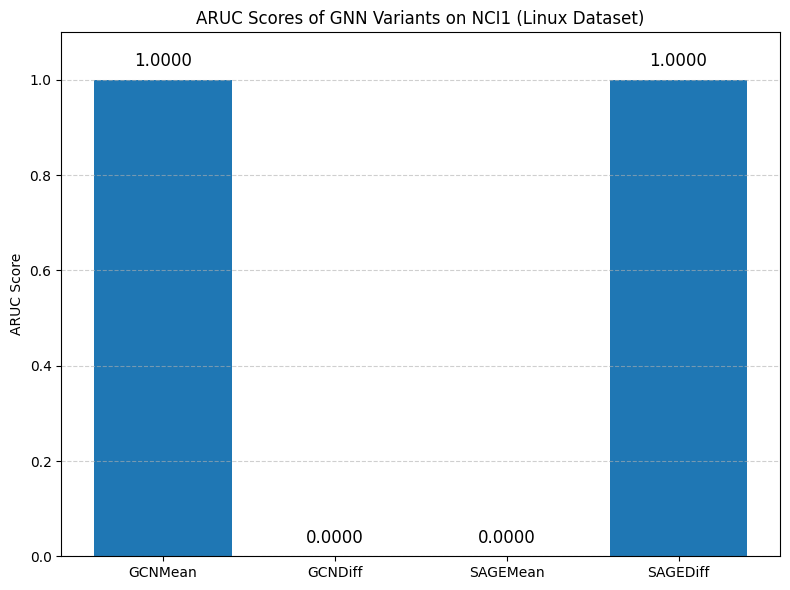

In [ ]:
import matplotlib.pyplot as plt

# ARUC scores for each model variant on NCI1 (Linux)
variants = ['GCNMean', 'GCNDiff', 'SAGEMean', 'SAGEDiff']
aruc_scores = [1.0000, 0.0000, 0.0000, 1.0000]

# Create bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(variants, aruc_scores)

# Add score labels on top of each bar
for bar, score in zip(bars, aruc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f'{score:.4f}',
             ha='center', va='bottom', fontsize=12)

# Styling
plt.ylim(0, 1.1)
plt.ylabel('ARUC Score')
plt.title('ARUC Scores of GNN Variants on NCI1 (Linux Dataset)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()
